In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from tensorflow.keras.datasets import mnist
from tensorflow import keras
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Lambda, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, LeakyReLU

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train[y_train==7]
y_train = y_train[y_train==7]

BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 100

length = BUFFER_SIZE // BATCH_SIZE * BATCH_SIZE
x_train = x_train[:length]
y_train = y_train[:length]
print(x_train.shape, y_train.shape)

# стандартизация входных данных
x_train = x_train / 255
x_test = x_test / 255

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))


train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE) 

(6200, 28, 28) (6200,)


In [4]:
# формирование сетей
hidden_dim = 2

def dropout_and_batch(x):
    return Dropout(0.3)(BatchNormalization()(x))

input_img = Input((28, 28, 1))
x = Flatten()(input_img)
x = Dense(256, activation='relu')(x)
x = dropout_and_batch(x)

z_mean = Dense(hidden_dim)(x)
z_log_var = Dense(hidden_dim)(x)

def noiser(args):
    global z_mean, z_log_var
    z_mean, z_log_var = args
    N = K.random_normal(shape=(BATCH_SIZE, hidden_dim), mean=0., stddev=1.0)
    return K.exp(z_log_var / 2) * N + z_mean

h = Lambda(noiser, output_shape=(hidden_dim,))([z_mean, z_log_var])

input_dec = Input(shape=(hidden_dim,))
d = Dense(256, activation='relu')(input_dec)
d = dropout_and_batch(d)
d = Dense(28*28, activation='sigmoid')(d)
decoded = Reshape((28, 28, 1))(d)

encoder = keras.Model(input_img, h, name='encoder')
decoder = keras.Model(input_dec, decoded, name='decoder')
generator = keras.Model(input_img, decoder(encoder(input_img)), name="generator")

# дискриминатор
discriminator = tf.keras.Sequential()
discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))

discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))

discriminator.add(Flatten())
discriminator.add(Dense(1))


In [5]:
# потери
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return (loss + kl_loss*0.1)


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [10]:
# обучение
@tf.function
def train_step(images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(images, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss



In [11]:
def train(dataset, epochs):
    history = []
    MAX_PRINT_LABEL = 10
    th = BUFFER_SIZE // (BATCH_SIZE*MAX_PRINT_LABEL)

    n_epoch = 1
    for epoch in range(epochs):
        print(f'{n_epoch}/{EPOCHS}: ', end='')

        start = time.time()
        n = 0

        gen_loss_epoch = 0
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_epoch += K.mean(gen_loss)
            if( n % th == 0): print('=', end='')
            n += 1

        history += [gen_loss_epoch/n]
        print(': '+str(history[-1]))
        print ('Время эпохи {} в {} секундах'.format(epoch + 1, time.time()-start))

        n_epoch += 1
    return history


1/50: ===========: tf.Tensor(2.648668, shape=(), dtype=float32)
Время эпохи 1 в 12.482148170471191 секундах
2/50: ===========: tf.Tensor(6.343383, shape=(), dtype=float32)
Время эпохи 2 в 11.900924921035767 секундах
3/50: ===========: tf.Tensor(11.118814, shape=(), dtype=float32)
Время эпохи 3 в 12.114499568939209 секундах
4/50: ===========: tf.Tensor(17.682863, shape=(), dtype=float32)
Время эпохи 4 в 11.514839172363281 секундах
5/50: ===========: tf.Tensor(23.2733, shape=(), dtype=float32)
Время эпохи 5 в 11.841586112976074 секундах
6/50: ===========: tf.Tensor(24.297295, shape=(), dtype=float32)
Время эпохи 6 в 12.593920707702637 секундах
7/50: ===========: tf.Tensor(21.533617, shape=(), dtype=float32)
Время эпохи 7 в 11.26884651184082 секундах
8/50: ===========: tf.Tensor(18.326017, shape=(), dtype=float32)
Время эпохи 8 в 10.165208101272583 секундах
9/50: ===========: tf.Tensor(16.639484, shape=(), dtype=float32)
Время эпохи 9 в 10.219656467437744 секундах
10/50: ===========: tf.T

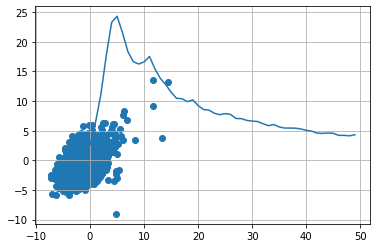

In [12]:
# запуск процесса обучения
EPOCHS = 50

history = train(train_dataset, EPOCHS)


h = encoder.predict(x_test[:6000], batch_size=BATCH_SIZE)
plt.scatter(h[:, 0], h[:, 1])

plt.plot(history)
plt.grid(True)

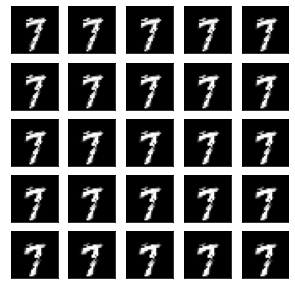

In [13]:
# отображение результатов генерации
n = 2
total = 2*n+1

plt.figure(figsize=(total, total))

num = 1
for i in range(-n, n+1):
    for j in range(-n, n+1):
        ax = plt.subplot(total, total, num)
        num += 1
        img = decoder.predict(np.expand_dims([0.5*i/n, 0.5*j/n], axis=0))
        plt.imshow(img.squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)